# Neural Machine Translation

We will build a Neural Machine Translation (NMT) model to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25"). We will do this using an attention model, one of the most sophisticated sequence to sequence models. 

Let's load all the packages.

In [23]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

## 1 - Translating human readable dates into machine readable dates

The model we will build here could be used to translate from one language to another, such as translating from English to Hindi. However, language translation requires massive datasets and usually takes days of training on GPUs. So we will instead use a simpler "date translation" task. 

The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) and translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 



<!-- 
Take a look at [nmt_utils.py](./nmt_utils.py) to see all the formatting. Count and figure out how the formats work, you will need this knowledge later. !--> 

### 1.1 - Dataset

We will train the model on a dataset of 10000 human readable dates and their equivalent, standardized, machine readable dates. Let's run the following cells to load the dataset and print some examples. 

In [24]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:01<00:00, 5974.53it/s]


Creating Train-Test dataset

In [25]:
random.shuffle(dataset)

train_data = dataset[:9000]
test_data = dataset[9000:]

In [26]:
dataset[:10]

[('wednesday march 28 2007', '2007-03-28'),
 ('10 october 2012', '2012-10-10'),
 ('1/29/88', '1988-01-29'),
 ('25 dec 2014', '2014-12-25'),
 ('22 march 1971', '1971-03-22'),
 ('january 4 1986', '1986-01-04'),
 ('10 january 1983', '1983-01-10'),
 ('june 18 2013', '2013-06-18'),
 ('31 december 2006', '2006-12-31'),
 ('wednesday june 20 2012', '2012-06-20')]

we've loaded:
- `dataset`: a list of tuples of (human readable date, machine readable date)
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index 
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Let's preprocess the data and map the raw text data into the index values. We will also use Tx=30 (which we assume is the maximum length of the human readable date; if we get a longer input, we would have to truncate it) and Ty=10 (since "YYYY-MM-DD" is 10 characters long). 

In [27]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(train_data, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (9000, 30)
Y.shape: (9000, 10)
Xoh.shape: (9000, 30, 37)
Yoh.shape: (9000, 10, 11)


We now have:
- `X`: a processed version of the human readable dates in the training set, where each character is replaced by an index mapped to the character via `human_vocab`. Each date is further padded to $T_x$ values with a special character (< pad >). `X.shape = (m, Tx)`
- `Y`: a processed version of the machine readable dates in the training set, where each character is replaced by the index it is mapped to in `machine_vocab`. You should have `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`, the "1" entry's index is mapped to the character thanks to `human_vocab`. `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`, the "1" entry's index is mapped to the character thanks to `machine_vocab`. `Yoh.shape = (m, Tx, len(machine_vocab))`. Here, `len(machine_vocab) = 11` since there are 11 characters ('-' as well as 0-9). 


Lets also look at some examples of preprocessed training examples.

In [28]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: wednesday march 28 2007
Target date: 2007-03-28

Source after preprocessing (indices): [33 17 16 25 17 29 16 13 34  0 24 13 28 15 20  0  5 11  0  5  3  3 10 36 36
 36 36 36 36 36]
Target after preprocessing (indices): [3 1 1 8 0 1 4 0 3 9]

Source after preprocessing (one-hot): [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
Target after preprocessing (one-hot): [[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]

## 2 - Neural machine translation with attention

If we had to translate a book's paragraph from French to English, we would not read the whole paragraph, then close the book and translate. Even during the translation process, we would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down. 

The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 


### 2.1 - Attention mechanism

The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>


In [29]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

Now you can use these layers to implement `one_step_attention()`. In order to propagate a Keras tensor object X through one of these layers, use `layer(X)` (or `layer([X,Y])` if it requires multiple inputs.), e.g. `densor(X)` will propagate X through the `Dense(1)` layer defined above.

In [30]:
# one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    
    
    return context

We will be able to check the expected output of `one_step_attention()` after we've coded the `model()` function.

In [31]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

Now we can use these layers $T_y$ times in a `for` loop to generate the outputs, and their parameters will not be reinitialized. We will have to carry out the following steps: 

1. Propagate the input into a [Bidirectional](https://keras.io/layers/wrappers/#bidirectional) [LSTM](https://keras.io/layers/recurrent/#lstm)
2. Iterate for $t = 0, \dots, T_y-1$: 
    1. Call `one_step_attention()` on $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$ and $s^{<t-1>}$ to get the context vector $context^{<t>}$.
    2. Give $context^{<t>}$ to the post-attention LSTM cell. Remember pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM using `initial_state= [previous hidden state, previous cell state]`. Get back the new hidden state $s^{<t>}$ and the new cell state $c^{<t>}$.
    3. Apply a softmax layer to $s^{<t>}$, get the output. 
    4. Save the output by adding it to the list of outputs.

3. Create your Keras model instance, it should have three inputs ("inputs", $s^{<0>}$ and $c^{<0>}$) and output the list of "outputs".

In [32]:
# model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
        
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    
        
    return model

Run the following cell to create the model.

In [33]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

Let's get a summary of the model.

In [34]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_2 (Bidirectional)  (None, 30, 64)        17920       input_2[0][0]                    
____________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_3[0][0]            

As usual, after creating our model in Keras, we need to compile it and define what loss, optimizer and metrics we want to use. Compile the model using `categorical_crossentropy` loss, a custom [Adam](https://keras.io/optimizers/#adam) [optimizer](https://keras.io/optimizers/#usage-of-optimizers) (`learning rate = 0.005`, $\beta_1 = 0.9$, $\beta_2 = 0.999$, `decay = 0.01`)  and `['accuracy']` metrics:

In [35]:

opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, metrics=['accuracy'], loss='categorical_crossentropy')

The last step is to define all our inputs and outputs to fit the model:
- We already have X of shape $(m = 10000, T_x = 30)$ containing the training examples.
- We need to create `s0` and `c0` to initialize our `post_activation_LSTM_cell` with 0s.
- Given the `model()` we coded, we need the "outputs" to be a list of 11 elements of shape (m, T_y). So that: `outputs[i][0], ..., outputs[i][Ty]` represent the true labels (characters) corresponding to the $i^{th}$ training example (`X[i]`). More generally, `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [36]:
s0 = np.zeros((m-1000, n_s))
c0 = np.zeros((m-1000, n_s))
outputs = list(Yoh.swapaxes(0,1))

Let's now fit the model and run it for one epoch.

In [37]:
model.fit([Xoh, s0, c0], outputs,validation_split=0.10 ,epochs=1, batch_size=50)

Train on 8100 samples, validate on 900 samples
Epoch 1/1
8100/8100 [==============================] - 44s - loss: 14.3919 - dense_6_loss_1: 0.9199 - dense_6_loss_2: 0.7716 - dense_6_loss_3: 1.5431 - dense_6_loss_4: 2.5523 - dense_6_loss_5: 0.5197 - dense_6_loss_6: 0.9988 - dense_6_loss_7: 2.4080 - dense_6_loss_8: 0.6200 - dense_6_loss_9: 1.5567 - dense_6_loss_10: 2.5018 - dense_6_acc_1: 0.6254 - dense_6_acc_2: 0.7632 - dense_6_acc_3: 0.3800 - dense_6_acc_4: 0.1012 - dense_6_acc_5: 0.9136 - dense_6_acc_6: 0.5322 - dense_6_acc_7: 0.1344 - dense_6_acc_8: 0.9381 - dense_6_acc_9: 0.2801 - dense_6_acc_10: 0.1098 - val_loss: 9.3974 - val_dense_6_loss_1: 0.2237 - val_dense_6_loss_2: 0.1731 - val_dense_6_loss_3: 1.0352 - val_dense_6_loss_4: 2.2025 - val_dense_6_loss_5: 0.0133 - val_dense_6_loss_6: 0.3674 - val_dense_6_loss_7: 1.8960 - val_dense_6_loss_8: 0.0168 - val_dense_6_loss_9: 1.2547 - val_dense_6_loss_10: 2.2147 - val_dense_6_acc_1: 0.9489 - val_dense_6_acc_2: 0.9489 - val_dense_6_acc_3:

While training we can see the loss as well as the accuracy on each of the 10 positions of the output. The table below gives us an example of what the accuracies could be if the batch had 2 examples: 

<img src="images/table.png" style="width:700;height:200px;"> <br>
<caption><center>Thus, `dense_6_acc_8: 0.9381` means that we are predicting the 7th character of the output correctly 93.8% of the time in the current batch of data. </center></caption>


We have run this model for longer, and saved the weights. Run the next cell to load our weights. (By training a model for several minutes, we should be able to obtain a model of similar accuracy, but loading our model will save us time.) 

In [38]:
model.load_weights('models/model.h5')

You can now see the results on new examples.

In [39]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, metrics=['accuracy'], loss='categorical_crossentropy')

In [41]:
model.fit([Xoh, s0, c0], outputs,validation_split=0.10 ,epochs=1, batch_size=50)

Train on 8100 samples, validate on 900 samples
Epoch 1/1
8100/8100 [==============================] - 38s - loss: 0.0239 - dense_6_loss_1: 0.0011 - dense_6_loss_2: 2.7899e-04 - dense_6_loss_3: 0.0022 - dense_6_loss_4: 0.0035 - dense_6_loss_5: 3.9940e-05 - dense_6_loss_6: 0.0050 - dense_6_loss_7: 0.0043 - dense_6_loss_8: 1.0838e-04 - dense_6_loss_9: 0.0056 - dense_6_loss_10: 0.0019 - dense_6_acc_1: 1.0000 - dense_6_acc_2: 1.0000 - dense_6_acc_3: 1.0000 - dense_6_acc_4: 1.0000 - dense_6_acc_5: 1.0000 - dense_6_acc_6: 0.9988 - dense_6_acc_7: 0.9998 - dense_6_acc_8: 1.0000 - dense_6_acc_9: 0.9994 - dense_6_acc_10: 0.9999 - val_loss: 0.0175 - val_dense_6_loss_1: 0.0011 - val_dense_6_loss_2: 1.7143e-04 - val_dense_6_loss_3: 0.0015 - val_dense_6_loss_4: 0.0029 - val_dense_6_loss_5: 3.7718e-05 - val_dense_6_loss_6: 0.0026 - val_dense_6_loss_7: 0.0034 - val_dense_6_loss_8: 9.0454e-05 - val_dense_6_loss_9: 0.0046 - val_dense_6_loss_10: 0.0011 - val_dense_6_acc_1: 1.0000 - val_dense_6_acc_2: 1.00

We use the test data now to evaluate the model

In [42]:
X_test, Y_test, Xoh, Yoh = preprocess_data(test_data, human_vocab, machine_vocab, Tx, Ty)

In [43]:
s0 = np.zeros((1000, n_s))
c0 = np.zeros((1000, n_s))
outputs = list(Yoh.swapaxes(0,1))

Evaluating the model 

In [44]:
acc = model.evaluate([Xoh, s0, c0], outputs)
print(acc)

 992/1000 [============================>.] - ETA: 0s[0.019812780089676379, 0.00083722129487432534, 0.00017791543859129889, 0.0018465473949909211, 0.003064362555742264, 3.5340806003659964e-05, 0.0055990931419655681, 0.0031990938433445991, 9.3631111201830213e-05, 0.0039900492113083604, 0.00096952567808330061, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0]


In [46]:
accuracy = 0
for i in range(11,21):
    accuracy += acc[i]
    
accuracy = accuracy/10
accuracy

0.9998999999999999

This is our accuracy . 

In [47]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-04-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


## 3 - Visualizing Attention 

Since the problem has a fixed output length of 10, it is also possible to carry out this task using 10 different softmax units to generate the 10 characters of the output. But one advantage of the attention model is that each part of the output (say the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what part of the output is looking at what part of the input.

Consider the task of translating "Saturday 9 May 2018" to "2018-05-09". If we visualize the computed $\alpha^{\langle t, t' \rangle}$ we get this: 

<img src="images/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 8**: Full Attention Map</center></caption>

Notice how the output ignores the "Saturday" portion of the input. None of the output timesteps are paying much attention to that portion of the input. We see also that 9 has been translated as 09 and May has been correctly translated into 05, with the output paying attention to the parts of the input it needs to to make the translation. The year mostly requires it to pay attention to the input's "18" in order to generate "2018." 



### 3.1 - Getting the activations from the network

Lets now visualize the attention values in your network. We'll propagate an example through the network, then visualize the values of $\alpha^{\langle t, t' \rangle}$. 

To figure out where the attention values are located, let's start by printing a summary of the model .

In [48]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_2 (Bidirectional)  (None, 30, 64)        17920       input_2[0][0]                    
____________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_3[0][0]            

Navigate through the output of `model.summary()` above. We can see that the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. Lets get the activations from this layer.

The function `attention_map()` pulls out the attention values from our model and plots them.

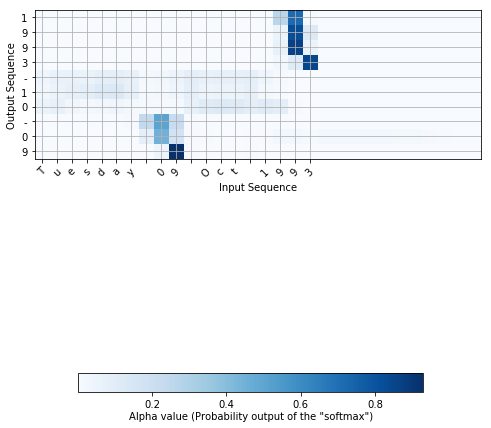

In [49]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)

On the generated plot we can observe the values of the attention weights for each character of the predicted output. We can examine this plot and check where the network is paying attention.